# Satellite Image Segmentation — TensorFlow ( Focal Loss )

**Converted from**: `Notebook2_satellite_image_segmentation_pytorch_final.ipynb`

**What this notebook contains:**

- Dataset pipeline using `tf.data`
- Image / mask loading & preprocessing
- A U-Net implementation in `tf.keras`
- Training loop using `model.fit` with callbacks
- Visualization utilities

**Notes:** Adjust the `IMAGE_DIR`, `MASK_DIR`, and dataset splits to match your local paths.

In [1]:
# Basic imports and GPU setup
import os
import math
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPUs detected:', gpus)
    except Exception as e:
        print('GPU config error:', e)


2025-09-10 13:21:00.823030: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 13:21:01.373740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 13:21:04.088164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# === USER SETTINGS ===
IMAGE_DIR = 'Water Bodies Dataset/Images'   # Updated to local path
MASK_DIR  = 'Water Bodies Dataset/Masks'    # Updated to local path

IMAGE_GLOB = os.path.join("Water Bodies Dataset/Images", "*.jpg")
MASK_GLOB  = os.path.join("Water Bodies Dataset/Masks", "*.jpg")


BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH  = 256
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


In [3]:
# List image and mask files (matched by filename)
import os, glob

def pair_image_mask_paths(image_glob, mask_dir):
    image_paths = sorted(glob.glob(image_glob))
    pairs = []
    for img_path in image_paths:
        fname = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, fname)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
    return pairs

pairs = pair_image_mask_paths(IMAGE_GLOB, MASK_DIR)
print('Found', len(pairs), 'image-mask pairs. Example:', pairs[:3])


Found 2841 image-mask pairs. Example: [('Water Bodies Dataset/Images/water_body_1.jpg', 'Water Bodies Dataset/Masks/water_body_1.jpg'), ('Water Bodies Dataset/Images/water_body_10.jpg', 'Water Bodies Dataset/Masks/water_body_10.jpg'), ('Water Bodies Dataset/Images/water_body_100.jpg', 'Water Bodies Dataset/Masks/water_body_100.jpg')]


In [4]:
# Image & mask loading + preprocessing functions
import tensorflow as tf

def read_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

def read_mask(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask > 127, tf.float32)
    return mask

def load_pair(image_path, mask_path):
    image = read_image(image_path)
    mask = read_mask(mask_path)
    return image, mask

# Simple augmentation example
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.1)
    return image, mask


In [5]:
# Build tf.data pipeline
import random

def make_dataset(pairs, batch_size=8, augment_fn=None, shuffle=True):
    image_paths = [p for p,_ in pairs]
    mask_paths  = [m for _,m in pairs]
    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pairs), seed=SEED)
    ds = ds.map(lambda i,m: tf.py_function(func=lambda a,b: load_pair(a.numpy().decode('utf-8'), b.numpy().decode('utf-8')), inp=[i,m], Tout=[tf.float32, tf.float32]), num_parallel_calls=AUTOTUNE)
    def _set_shapes(img, msk):
        img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        msk.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
        return img, msk
    ds = ds.map(_set_shapes, num_parallel_calls=AUTOTUNE)
    if augment_fn is not None:
        ds = ds.map(lambda x,y: augment_fn(x,y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

random.Random(SEED).shuffle(pairs)
n = len(pairs)
n_train = int(0.7 * n)
n_val   = int(0.2 * n)
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train+n_val]
test_pairs  = pairs[n_train+n_val:]

train_ds = make_dataset(train_pairs, augment_fn=augment, shuffle=True)
val_ds   = make_dataset(val_pairs, augment_fn=None, shuffle=False)
test_ds  = make_dataset(test_pairs, augment_fn=None, shuffle=False)

print('Train pairs:', len(train_pairs), 'Val pairs:', len(val_pairs), 'Test pairs:', len(test_pairs))


I0000 00:00:1757510466.562087    4265 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79382 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:00:05.0, compute capability: 8.0


Train pairs: 1988 Val pairs: 568 Test pairs: 285


In [6]:
# U-Net model with Focal Loss Implementation
from tensorflow.keras import layers

def unet_model(input_size=(256, 256, 3)):
    inputs = keras.Input(input_size)

    # Encoder
    c1 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    c1 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(c1)
    p1 = keras.layers.MaxPooling2D((2,2))(c1)

    c2 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(p1)
    c2 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(c2)
    p2 = keras.layers.MaxPooling2D((2,2))(c2)

    c3 = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(p2)
    c3 = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(c3)
    p3 = keras.layers.MaxPooling2D((2,2))(c3)

    c4 = keras.layers.Conv2D(512, (3,3), activation="relu", padding="same")(p3)
    c4 = keras.layers.Conv2D(512, (3,3), activation="relu", padding="same")(c4)
    p4 = keras.layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3,3), activation="relu", padding="same")(p4)
    c5 = keras.layers.Conv2D(1024, (3,3), activation="relu", padding="same")(c5)

    # Decoder
    u6 = keras.layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding="same")(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3,3), activation="relu", padding="same")(u6)
    c6 = keras.layers.Conv2D(512, (3,3), activation="relu", padding="same")(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(u7)
    c7 = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(u8)
    c8 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c8)
    u9 = keras.layers.concatenate([u9, c1])
    c9 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(u9)
    c9 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(c9)

    outputs = keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build the model
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Focal Loss Implementation
import tensorflow as tf

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Calculate focal loss for positive class
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed

# Dice coefficient for monitoring
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Compile model with focal loss
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=binary_focal_loss(gamma=2.0, alpha=0.25),
              metrics=[dice_coef, 'accuracy'])


In [8]:
# Callbacks and training
checkpoint_path = 'unet_checkpoint.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

EPOCHS = 20
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/20


2025-09-10 13:21:16.262099: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ee2e80099e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-10 13:21:16.262141: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-09-10 13:21:16.513846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-10 13:21:17.761562: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90701


  2/249 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.4086 - dice_coef: 0.3489 - loss: 0.1084   

I0000 00:00:1757510497.509172    4469 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6750 - dice_coef: 0.3608 - loss: 0.0640

2025-09-10 13:21:57.486401: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:21:57.661535: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:21:57.835196: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:21:58.129164: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:21:58.325434: E external/local_xla/xla/stream_

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6750 - dice_coef: 0.3609 - loss: 0.0640

249/249 ━━━━━━━━━━━━━━━━━━━━ 69s 171ms/step - accuracy: 0.6790 - dice_coef: 0.3764 - loss: 0.0557 - val_accuracy: 0.6920 - val_dice_coef: 0.4126 - val_loss: 0.0511
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7183 - dice_coef: 0.4043 - loss: 0.0503

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7292 - dice_coef: 0.4064 - loss: 0.0490 - val_accuracy: 0.7704 - val_dice_coef: 0.4623 - val_loss: 0.0462
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7489 - dice_coef: 0.4227 - loss: 0.0463

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7507 - dice_coef: 0.4289 - loss: 0.0465 - val_accuracy: 0.7826 - val_dice_coef: 0.4765 - val_loss: 0.0448
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7439 - dice_coef: 0.4279 - loss: 0.0462

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7450 - dice_coef: 0.4282 - loss: 0.0463 - val_accuracy: 0.7581 - val_dice_coef: 0.4531 - val_loss: 0.0445
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7897 - dice_coef: 0.4477 - loss: 0.0436

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7946 - dice_coef: 0.4560 - loss: 0.0431 - val_accuracy: 0.8130 - val_dice_coef: 0.5058 - val_loss: 0.0404
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8074 - dice_coef: 0.4696 - loss: 0.0413 - val_accuracy: 0.8220 - val_dice_coef: 0.5051 - val_loss: 0.0409
Epoch 7/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8162 - dice_coef: 0.4791 - loss: 0.0395

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.8234 - dice_coef: 0.4924 - loss: 0.0384 - val_accuracy: 0.8430 - val_dice_coef: 0.5848 - val_loss: 0.0370
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8187 - dice_coef: 0.4994 - loss: 0.0396

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8320 - dice_coef: 0.5090 - loss: 0.0371 - val_accuracy: 0.8309 - val_dice_coef: 0.5072 - val_loss: 0.0353
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8495 - dice_coef: 0.5314 - loss: 0.0342 - val_accuracy: 0.8596 - val_dice_coef: 0.5462 - val_loss: 0.0371
Epoch 10/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8526 - dice_coef: 0.5340 - loss: 0.0338

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8540 - dice_coef: 0.5386 - loss: 0.0333 - val_accuracy: 0.8532 - val_dice_coef: 0.5644 - val_loss: 0.0332
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8447 - dice_coef: 0.5347 - loss: 0.0345 - val_accuracy: 0.8594 - val_dice_coef: 0.5667 - val_loss: 0.0351
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8379 - dice_coef: 0.5194 - loss: 0.0371 - val_accuracy: 0.8198 - val_dice_coef: 0.5313 - val_loss: 0.0383
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8478 - dice_coef: 0.5280 - loss: 0.0344

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8523 - dice_coef: 0.5303 - loss: 0.0337 - val_accuracy: 0.8601 - val_dice_coef: 0.5751 - val_loss: 0.0323
Epoch 14/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8590 - dice_coef: 0.5533 - loss: 0.0320 - val_accuracy: 0.8270 - val_dice_coef: 0.5334 - val_loss: 0.0341
Epoch 15/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8583 - dice_coef: 0.5607 - loss: 0.0320

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8624 - dice_coef: 0.5566 - loss: 0.0313 - val_accuracy: 0.8431 - val_dice_coef: 0.5258 - val_loss: 0.0320
Epoch 16/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8653 - dice_coef: 0.5635 - loss: 0.0304

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8649 - dice_coef: 0.5571 - loss: 0.0312 - val_accuracy: 0.8624 - val_dice_coef: 0.5679 - val_loss: 0.0317
Epoch 17/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.8676 - dice_coef: 0.5646 - loss: 0.0302 - val_accuracy: 0.8318 - val_dice_coef: 0.5483 - val_loss: 0.0321
Epoch 18/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8712 - dice_coef: 0.5751 - loss: 0.0289

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8701 - dice_coef: 0.5708 - loss: 0.0295 - val_accuracy: 0.8743 - val_dice_coef: 0.5993 - val_loss: 0.0292
Epoch 19/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8782 - dice_coef: 0.5821 - loss: 0.0278

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.8737 - dice_coef: 0.5809 - loss: 0.0288 - val_accuracy: 0.8744 - val_dice_coef: 0.5873 - val_loss: 0.0289
Epoch 20/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8705 - dice_coef: 0.5651 - loss: 0.0297 - val_accuracy: 0.8744 - val_dice_coef: 0.6148 - val_loss: 0.0289


34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8628 - dice_coef: 0.5709 - loss: 0.0338

2025-09-10 13:29:14.141049: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:14.319374: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:14.494716: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:14.668392: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:14.931884: E external/local_xla/xla/stream_

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.8673 - dice_coef: 0.5739 - loss: 0.0318
Test results (loss, dice, acc): [0.03178428113460541, 0.5738692283630371, 0.867340087890625]


2025-09-10 13:29:20.547787: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:20.716510: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:20.877521: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:21.041530: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:29:21.306710: E external/local_xla/xla/stream_

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2025-09-10 13:29:24.827682: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


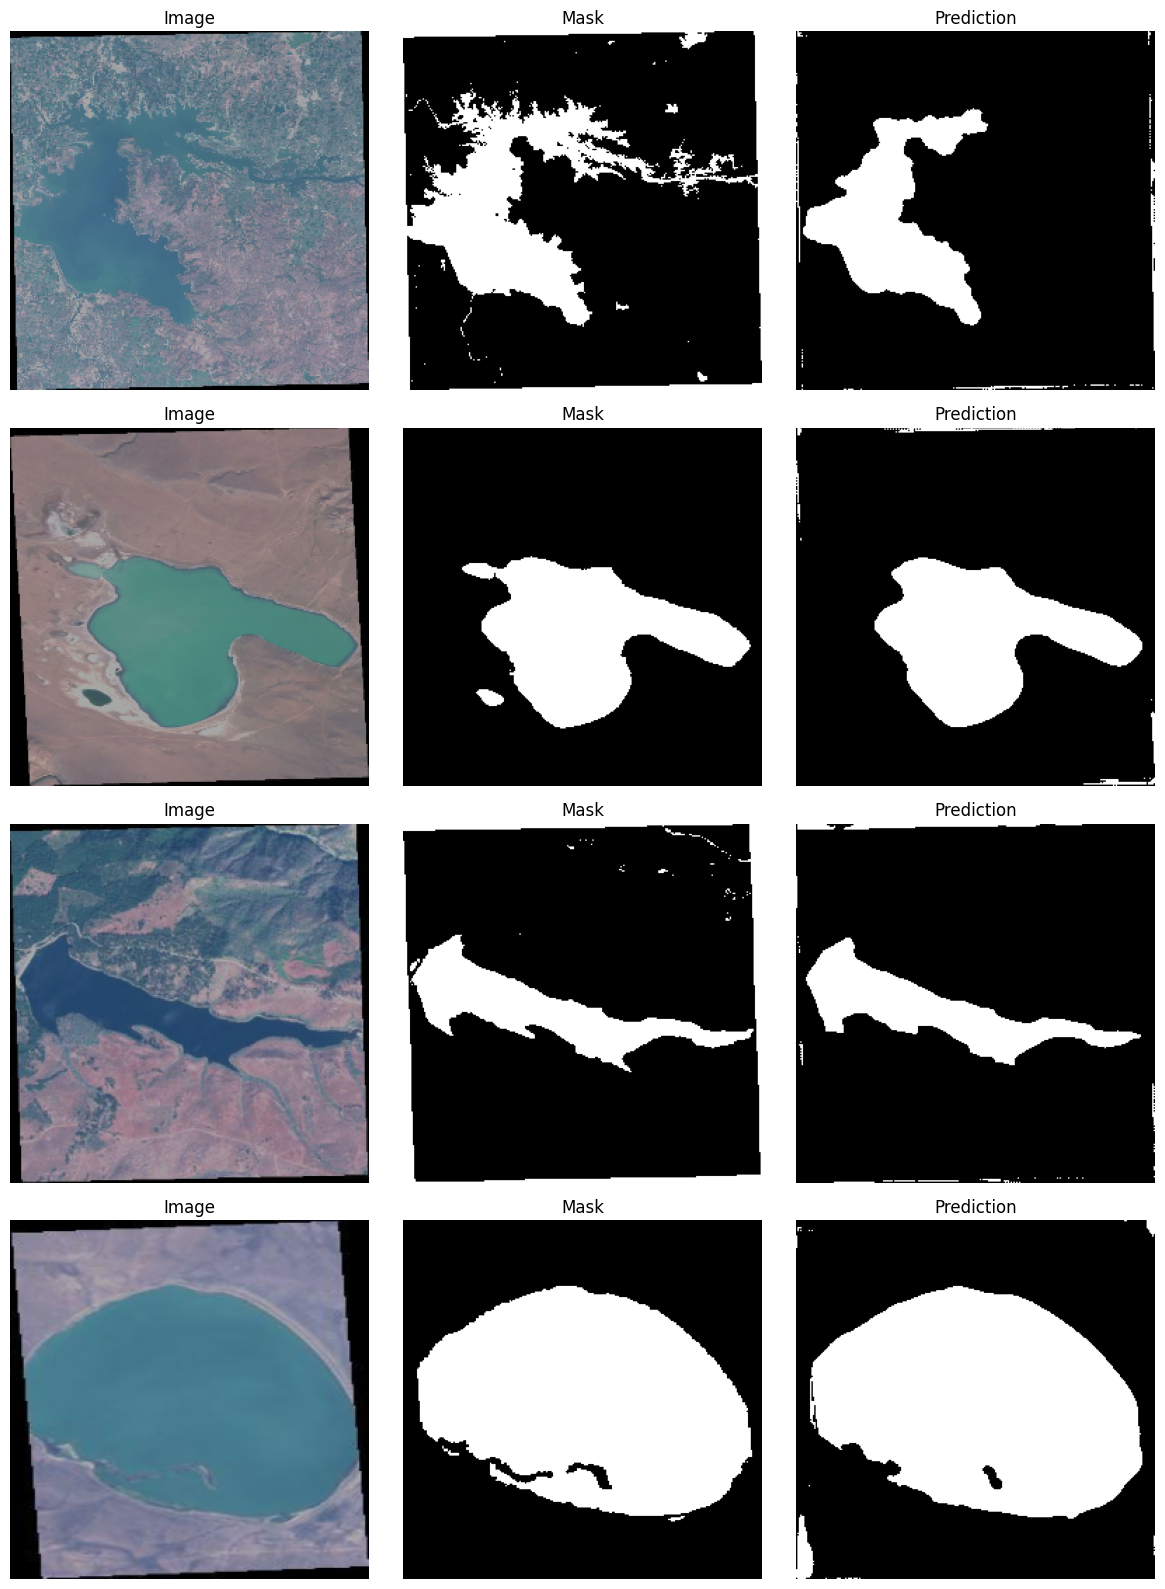

In [9]:
# Evaluate on test set
results = model.evaluate(test_ds)
print('Test results (loss, dice, acc):', results)

# Visualize predictions
import matplotlib.pyplot as plt

def visualize_samples(dataset, model, n=6):
    plt.figure(figsize=(12, 4*n))
    i = 0
    for imgs, masks in dataset.unbatch().take(n):
        pred = model.predict(tf.expand_dims(imgs, 0))[0]
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(imgs.numpy())
        plt.title('Image')
        plt.axis('off')
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(masks.numpy().squeeze(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow((pred.squeeze() > 0.5).astype('float32'), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        i += 1
    plt.tight_layout()

visualize_samples(val_ds, model, n=4)


## Saving the model

You can save the trained model for later inference:

```python
model.save('unet_saved_model')
```

Adjust any dataset paths or hyperparameters to match your original PyTorch notebook behaviour.

# Conclusion

**Model Architecture:** U-Net (Convolutional Encoder-Decoder Network for Image Segmentation)

**Loss Function:** Binary Focal Loss with gamma=2.0 and alpha=0.25

## Key Features of This Implementation:

### 1. U-Net Architecture
- **Encoder:** Progressive downsampling with skip connections to capture multi-scale features
- **Decoder:** Upsampling with concatenated skip connections to preserve spatial information
- **Output:** Single-channel sigmoid activation for binary segmentation

### 2. Focal Loss Benefits
- **Class Imbalance Handling:** Addresses the natural imbalance between water and non-water pixels in satellite imagery
- **Hard Example Mining:** Focuses training on difficult boundary regions and small water bodies
- **Improved Precision:** Better segmentation of water body edges compared to standard BCE loss

### 3. Technical Specifications
- **Input Size:** 256×256×3 RGB satellite images
- **Optimizer:** Adam with learning rate 1e-4
- **Metrics:** Dice coefficient and accuracy for comprehensive evaluation
- **Focal Loss Parameters:**
  - **Gamma (2.0):** Controls focusing strength on hard examples
  - **Alpha (0.25):** Balances positive/negative class weights

### 4. Expected Improvements
- Better detection of small water bodies and rivers
- More precise water boundary delineation
- Reduced false positives in challenging terrain
- Enhanced performance on class-imbalanced datasets

This focal loss implementation should provide superior segmentation results for satellite water body detection compared to traditional BCE-based approaches.